# General Ideas

In [1]:
%run publish.py

## Scoring rules

We start with a loose definition of a scoring auction in a procurement environment

:::{admonition} Definition
:class: important
A **scoring auction** is an auction where the winner is determined not by the strongest bid, but by the strongest  **score** - a function of bid and certain quality characteristics. A function that compiles bid and quality into a score is called a **scoring rule**.
:::

:::{dropdown} Read from Handbook of Procurement
When quality is a crucial component of a procurement contract and flexibility is needed to handle the trade-off between price and quality, scoring mechanisms are particularly appropriate. Should this be the case, pro-curement contracts for goods and services are awarded taking into accountsome non-price attributes that include various measures of quality... For instance, in the procurement of personal computers, hard disks, screen dimension, weight, etc., are valuable technical aspects for end-users, and the buyer is likely to take them into account in the design of the procurement strategy
:::

A scoring rule can take one of the following forms
1. **linear** score $s = \alpha q + d$
2. **quality-to-price ratio** $s = q/b$
3. multiplicative score $s = q d$
4. log-linear score $s = q^{\alpha} d$
5. **interdependent** scores like $s = \alpha q/q_{max} + d$ and many others

where $r$ is the **reserve price**, sometimes referred to as *starting price* or *maximal price*, and $d = r - b$ is the **discount**, and $d/r$ is the **percentage discount**.

:::{note}
Scoring rules are defined up to a monotone transformation, so 

$$s = - b/q, \quad s = q/b, \quad s = \log q - \log b$$ 

are the same scoring rule really.
:::

What we refer to as **quality** is also often multi-dimensional, in which case we interpret $q$ as a *quality index* - typically a weighted average of multiple quality characteristics. To grasp what a typical data generated by a scoring auction could look like, consider a simulation below:

In [4]:
columns = ['q-year', 'q-exp', 'q-prop', 
           'q-index', 'bid', 'reserve', 'score']

size = 1000

y = np.random.randint(1,10,size)
e = np.random.randint(0,100,size)
p = np.random.randint(0,100,size)
q = .1*y/10 + .5*e/100 + .4*p/100
b = np.maximum(100, np.round(1000*q + 100*np.random.normal(0,1,size), 2))
r = np.round(np.ones(size)*np.max(b) + np.random.uniform(0, 1000, size), 2)
s = np.round(.3*q + .7*(r-b)/r, 2)

df = pd.DataFrame(np.vstack((y,e,p,q,b,r,s)).T, columns = columns)

publish(df.head())

+----+----------+---------+----------+-----------+--------+-----------+---------+
|    |   q-year |   q-exp |   q-prop |   q-index |    bid |   reserve |   score |
+====+==========+=========+==========+===========+========+===========+=========+
|  0 |        5 |      13 |       56 |     0.339 | 407.63 |   1189.55 |    0.56 |
+----+----------+---------+----------+-----------+--------+-----------+---------+
|  1 |        2 |      37 |       18 |     0.277 | 168.3  |   1403.87 |    0.7  |
+----+----------+---------+----------+-----------+--------+-----------+---------+
|  2 |        4 |      37 |       25 |     0.325 | 357.8  |   2045.83 |    0.68 |
+----+----------+---------+----------+-----------+--------+-----------+---------+
|  3 |        8 |      81 |       19 |     0.561 | 530.8  |   1521.69 |    0.62 |
+----+----------+---------+----------+-----------+--------+-----------+---------+
|  4 |        4 |      75 |       39 |     0.571 | 728.53 |   1447.08 |    0.52 |
+----+----------

In the table above we have three underlying quality characteristics: *q_year* (years in the market), *q_exp* (experience), *q_prop* (proposition), that are weighted into a single quality index *q_index*. This index is then weighted against the discount, which is not present in the table explicitly. Note that you do not need to have access to all of the variables, some of them are clearly linearly dependent. Alternatively, you might not know the scoring rule, in which case you have to guess it from the data.

Let's see how our simulated data is distributed:

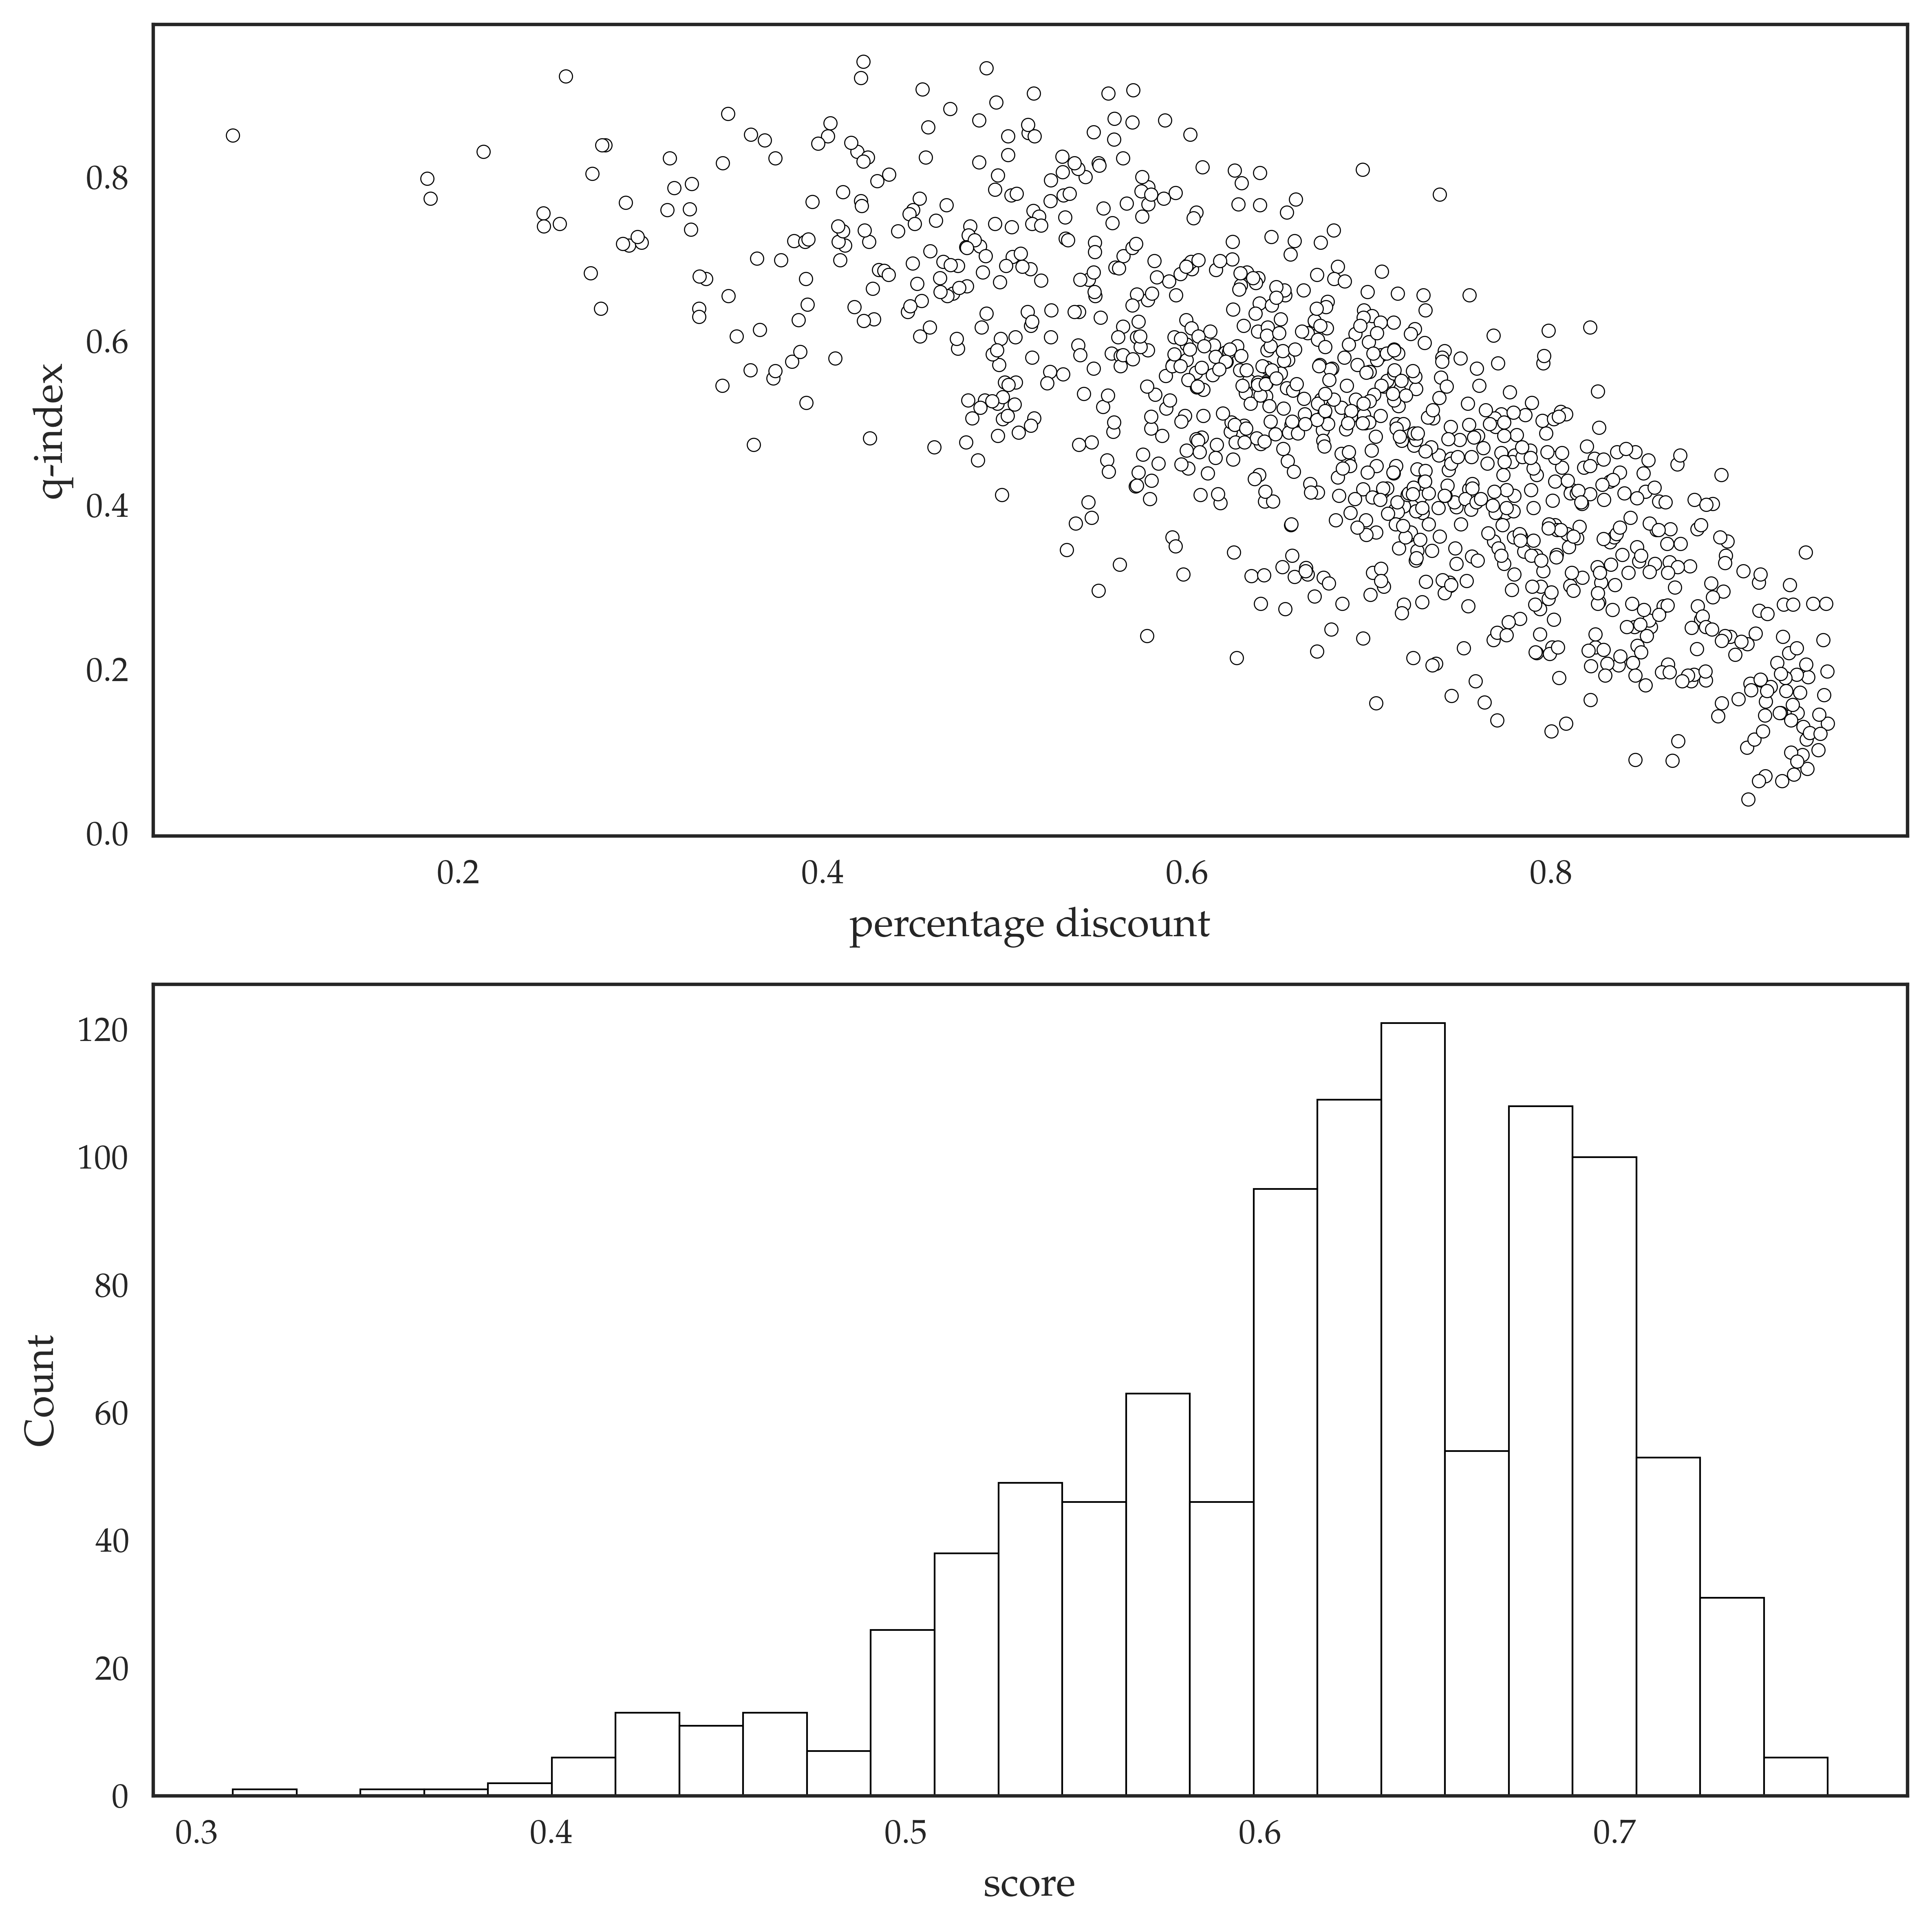

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1)

df['percentage discount'] = (df.reserve - df.bid)/df.reserve

sb.scatterplot(x = 'percentage discount', y = 'q-index', data = df, ax = ax1, **options_scatter);
sb.histplot(df.score, ax = ax2, **options_hist);

publish(fig)

It is natural to expect that quality and discount should be negatively correlated as higher quality is associated with higher costs. However, in practice, the correlation can be actually positive due to strategic reasons (non-monotonicity of monopoly price in demand).

:::{note}
The theory of **interdependent scoring rules** is virtually non-existent, yet they are quite popular in practice. Russian Federation and Italy have been experimenting a lot with complex auction rules, including scoring.
:::

## Nature of quality

The quality characteristics can be of different nature. For example, some of them could be completely **exogenous**, like the number of years firm has been operating on the market. These are ojective characteristics of the firm and can not be changed. An example of **endogenous** quality is when the firm submits the number of days needed to complete a certain construction project. The firm has complete freedom to claim any number of days: 30, 100, 300... but her associated costs would probably be higher as well. It is not always possible to say with complete certainty whether quality is exogenous or endogenous.

Another problem is that quality is not always completely objective and therefore is subject to **manipulation** (i.e. corruption), see, for example, [An empirical study of scoring auctions and quality manipulation corruption, EER, 2019](https://github.com/pandreyanov/grad_micro_lectures/blob/main/_assets/papers/scoring_auctions/huang19.pdf). When the risk of manipulation is low, it is possible to not commit to any particular evaluation criteria, or announce the criteria afted the proposals were submitted, so that the buyer has the last word. When the risk of manipulation is high, it makes more sense to commit to  strict and standardized evaluation criteria.

:::{dropdown} Read from Handbook of Procurement
Detailed ex-ante specifications increase the predictability of procurement competition, minimizing risks of discretionary behaviour and abuses of the evaluating committee (e.g., corruption). This comes at the cost of losing some flexibility. Therefore, the buyer should carefully evaluate and compare case by case costs and benefits of both flexibility and predictability. When corruption is not a particular concern and participants can offer different valuable solutions for the good or service to be procured, it is more likely that benefits from flexibility prevail. In this case, there can be much to gain from ex-post evaluation. In contrast, if corruption during the evaluation process is a concern, ex-post flexibility should be minimized either by adopting an ex-ante BME (automatic scoring) or, in case this were not possible, by reducing the weight given to technical attributes.
:::

Yet another problem is that certain quality characteristics and highly endogenous, but the associated costs are **sunk costs**, that is, they are incurred independently of the fact whether the firm wins the auction or not. Most of the time we would like the costs to be not sunk, that is, if the firm loses the auction, she can recover most of her investments. An exception is costs associated with mechanically filing the application. Since they do not vary across the firms, these are called **entry costs**.

:::{note}
The theory of scoring auctions with **sunk costs**, other than **entry costs**, is very difficult.
:::

As an exercise, speculate, where do these quality characteristics:

- number of contracts in the past
- access to special equipment (crane)
- access to skilled labor (architect)
- design blueprints (fighter jet, nuclear plant, bridge)
- design prototype (same)

belong on the spectrum between exogenous and endogenous, sunk and manipulable.